In [1]:
# Libraries
import itertools
from importlib import resources
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import random
import time

from drdt.helper_functions import DecisionRuleCreatorFromDecisionTable, Reduction, R_SR, R_AD, SAlphaStep, SPlus, SMax, NCover, NGreedy
from drdt.algorithms import DynamicProgrammingAlgorithms, A_C_N, A_C_G
from drdt.helper_functions import DecisionRuleCreatorFromDecisionTable
pd.options.mode.chained_assignment = None


In [2]:
problems = ['AR', 'EAR', 'SR', 'ESR', 'AD', 'EAD']
dataset_name = "Chess"

DP = []
NC = []
NCgreedy = []
Gr = []

# Loading Data

In [3]:
with resources.path('datasets.DecisionRuleSystems', 'DRS_chess') as dataset_path:
    S = pd.read_csv(dataset_path).applymap(lambda x: str(x) if pd.notnull(x) else x)
S = S.dropna(axis=1, how='all') # Drop the columns with all None
S

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,skrxp,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,class
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,nowin
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,nowin
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,nowin
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,t,NaN,NaN,NaN,NaN,nowin
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,won
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nowin
3129,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,won
3130,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,won
3131,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,won


# Dataset Analyses

In [4]:
n = len(S.columns)-1
print(f"Number of features  = {n}")

Number of features  = 35


In [5]:
print(f"Does # of features = d  = {not S.dropna().empty}")

Does # of features = d  = False


In [6]:
# Count non-NaN values for each row
non_nan_counts = S.count(axis=1)

# Find the index
max_non_nan_row_index = non_nan_counts.idxmax()

# Retrieve the row
max_non_nan_row = S.loc[max_non_nan_row_index]

# Number of non-NaN values in the row
max_non_nan_count = non_nan_counts[max_non_nan_row_index]

d = max_non_nan_count - 1

print(f"d = {d}") # remove 1 because of last class column

d = 11


In [7]:
P = S
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for AR = {len(B)}")

Length of Node Cover for AR = 11


In [8]:
P = R_SR(S)
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for SR = {len(B)}")

Length of Node Cover for SR = 11


In [9]:
P = R_AD(S)
P_plus = SPlus(P)
B = NCover(P_plus)
print(f"Length of Node Cover for AD = {len(B)}")

Length of Node Cover for AD = 11


In [10]:
P = S
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for AR = {len(B)}")

Length of Node Cover greedy for AR = 1


In [11]:
P = R_SR(S)
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for SR = {len(B)}")

Length of Node Cover greedy for SR = 1


In [12]:
P = R_AD(S)
P_plus = SPlus(P)
B = NGreedy(P_plus)
print(f"Length of Node Cover greedy for AD = {len(B)}")

Length of Node Cover greedy for AD = 1


# Combinations

In [13]:
column_values = []

for column in S.columns[:-1]:  # ignoring class column
    unique_values = list(S[column].dropna().unique())
    random.shuffle(unique_values)  # Shuffling the unique values list
    column_values.append(unique_values)

combinations_iterator = itertools.product(*column_values)

combinations = list(itertools.islice(combinations_iterator, 100))

In [14]:
column_values_extension = []

for column in S.columns[:-1]:  # ignoring class column
    unique_values_extension = list(S[column].dropna().unique()) + ['*']
    random.shuffle(unique_values_extension)  # Shuffling the unique values list
    column_values_extension.append(unique_values_extension)

extended_combinations_iterator = itertools.product(*column_values_extension)

extended_combinations = list(itertools.islice(extended_combinations_iterator, 100))

# Node Cover

In [15]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.60it/s]

NC AR
(Max Depth, Min Depth, Average Depth) = (35, 35, 35.0)
Running time = 17.891762256622314


In [16]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]

NC EAR
(Max Depth, Min Depth, Average Depth) = (35, 35, 35.0)
Running time = 13.63917589187622


In [17]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="SR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:15:29<00:00, 81.29s/it]

NC SR
(Max Depth, Min Depth, Average Depth) = (11, 11, 11.0)
Running time = 8129.414269924164


In [18]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="ESR", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:13:21<00:00, 80.01s/it]

NC ESR
(Max Depth, Min Depth, Average Depth) = (11, 11, 11.0)
Running time = 8001.114714860916


In [19]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AD", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:28:59<00:00, 53.40s/it]

NC AD
(Max Depth, Min Depth, Average Depth) = (34, 17, 20.06)
Running time = 5339.858582019806


In [20]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAD", N="cover")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NC EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NC.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:28:23<00:00, 53.03s/it]

NC EAD
(Max Depth, Min Depth, Average Depth) = (15, 15, 15.0)
Running time = 5303.381166934967


# Node Cover Greedy

In [21]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]

NCgreedy AR
(Max Depth, Min Depth, Average Depth) = (35, 35, 35.0)
Running time = 46.06635499000549


In [22]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]

NCgreedy EAR
(Max Depth, Min Depth, Average Depth) = (35, 34, 34.46)
Running time = 36.45279097557068


In [23]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="SR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:50:58<00:00, 102.59s/it]

NCgreedy SR
(Max Depth, Min Depth, Average Depth) = (14, 13, 13.36)
Running time = 10258.603636026382


In [24]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="ESR", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:50:33<00:00, 102.34s/it]

NCgreedy ESR
(Max Depth, Min Depth, Average Depth) = (4, 4, 4.0)
Running time = 10233.93066906929


In [25]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="AD", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:02:59<00:00, 73.79s/it]

NCgreedy AD
(Max Depth, Min Depth, Average Depth) = (16, 15, 15.36)
Running time = 7379.432109117508


In [26]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_N(C="EAD", N="greedy")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("NCgreedy EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
NCgreedy.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:55:21<00:00, 69.22s/it]

NCgreedy EAD
(Max Depth, Min Depth, Average Depth) = (25, 11, 15.86)
Running time = 6921.822078943253


# Greedy

In [27]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="AR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy AR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.77it/s]

Greedy AR
(Max Depth, Min Depth, Average Depth) = (35, 35, 35.0)
Running time = 36.11835503578186


In [28]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="EAR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy EAR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]

Greedy EAR
(Max Depth, Min Depth, Average Depth) = (34, 33, 33.4)
Running time = 12.840896129608154


In [29]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="SR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy SR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:44:48<00:00, 98.89s/it]

Greedy SR
(Max Depth, Min Depth, Average Depth) = (14, 6, 9.72)
Running time = 9888.999020814896


In [30]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="ESR")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy ESR")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:42:13<00:00, 97.33s/it]

Greedy ESR
(Max Depth, Min Depth, Average Depth) = (16, 11, 13.57)
Running time = 9733.492971897125


In [31]:
start_time = time.time()

depths = []

for comb in tqdm(combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="AD")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy AD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:55:32<00:00, 69.32s/it]

Greedy AD
(Max Depth, Min Depth, Average Depth) = (15, 12, 13.68)
Running time = 6932.396778106689


In [32]:
start_time = time.time()

depths = []

for comb in tqdm(extended_combinations):
    #creating delta
    delta = pd.DataFrame([list(comb)], columns=list(S.columns[:-1]))
    
    delta = delta.loc[0]
    
    alg = A_C_G(C="EAD")
    
    depth, _ = alg.solve(S, delta=delta)
    
    depths.append(depth)
    
end_time = time.time()
    
print("Greedy EAD")    
print("(Max Depth, Min Depth, Average Depth) =", (max(depths), min(depths), sum(depths)/len(depths)))
Gr.append((max(depths), min(depths), round(sum(depths)/len(depths), 2)))
print("Running time =", end_time - start_time)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:03:22<00:00, 74.03s/it]

Greedy EAD
(Max Depth, Min Depth, Average Depth) = (18, 17, 17.73)
Running time = 7402.547484874725


# PLOTS

ValueError: could not broadcast input array from shape (0,) into shape (6,)

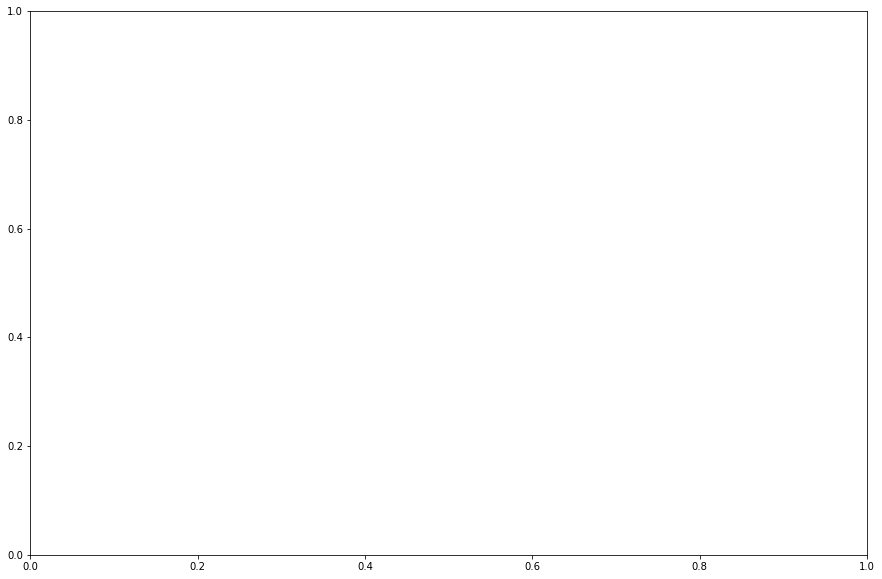

In [33]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[0], 0, DP, color='y', linewidth=15, label='Dynamic Programming')
plt.vlines(problem_indices + x_offsets[1], 0, [a for a,_,_ in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for a,_,_ in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for a,_,_ in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Max of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()


In [ ]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[1], 0, [a for _,a,_ in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for _,a,_ in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for _,a,_ in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Min of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
problem_indices = np.arange(len(problems))

plt.figure(figsize=(15,10))

offset = 0.1
x_offsets = np.array([-1.5*offset, -0.5*offset, 0.5*offset, 1.5*offset])

plt.vlines(problem_indices + x_offsets[1], 0, [a for _,_,a in Gr], color='g', linewidth=15, label='Greedy')
plt.vlines(problem_indices + x_offsets[2], 0, [a for _,_,a in NCgreedy], color='orange', linewidth=15, label='Node Cover Greedy')
plt.vlines(problem_indices + x_offsets[3], 0, [a for _,_,a in NC], color='b', linewidth=15, label='Node Cover')

plt.axhline(y=n, color='r', linestyle='--', linewidth=2, label=f'n={n}')

plt.xticks(problem_indices, problems, rotation=45, ha='right')

plt.title(f'Average of min depth {dataset_name}', fontsize=14)
plt.xlabel('Problems', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.show()